In [209]:
import midi_functions
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout, Flatten
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import callbacks
from keras import optimizers

from IPython.display import clear_output

#import pydot as pyd
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot


In [188]:
X = np.loadtxt('X.txt')
Y = np.loadtxt('Y.txt')

n = len(X)
permutation = np.random.permutation(n)
X = X[permutation]
Y = Y[permutation]

sorted_notes = np.copy(Y)
sorted_notes.sort()
sorted_notes = np.unique(sorted_notes)

number_of_different_notes = len(sorted_notes)
print('Number of different notes: {}'.format(number_of_different_notes))

max_note = np.max(Y)
X = X / max_note #normalize input

for i,note in enumerate(Y): #make all the notes a number between 0 and number_of_different_notes
    Y[i] = np.where(sorted_notes == note)[0]
Y = np_utils.to_categorical(Y)

print(X.shape)

#X_val = X[:1000]
#Y_val = Y[:1000]
#X_train = X[1000:]
#Y_train = Y[1000:]
#print(X_train.shape)

Number of different notes: 67
(9976, 10)


In [193]:
input_length = 10
#input_dimensions = (input_length,1)

n_hidden_units = number_of_different_notes #this should probably be the number of different notes since it is also the output of softmax

model = Sequential()
model.add(LSTM(
    256,
    input_shape=((input_length,1)),
    return_sequences=True
))
model.add(LSTM(n_hidden_units, return_sequences=False))
#model.add(Dropout(0.3))
model.add(Dense(n_hidden_units))
model.add(Activation('softmax'))
rmsprop = optimizers.RMSprop(lr=0.002, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
# Load the weights to each node
#model.load_weights('weights.hdf5')


#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
print(model.summary())
#print(model.get_weights())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 10, 256)           264192    
_________________________________________________________________
lstm_44 (LSTM)               (None, 67)                86832     
_________________________________________________________________
dense_2 (Dense)              (None, 67)                4556      
_________________________________________________________________
activation_23 (Activation)   (None, 67)                0         
Total params: 355,580
Trainable params: 355,580
Non-trainable params: 0
_________________________________________________________________
None


In [181]:
class live_plot(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.index = 0
        self.epochs = []
        
        self.losses = []
        self.val_losses = []
        
        self.acc = []
        self.val_acc = []
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.epochs.append(self.index)
        
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs['val_acc'])
        self.index += 1
        
        clear_output(wait=True)
        plt.plot(self.epochs, self.losses, label="loss")
        plt.plot(self.epochs, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
        plt.plot(self.epochs, self.acc, label="acc")
        plt.plot(self.epochs, self.val_acc, label="val_acc")
        plt.legend()
        plt.show();

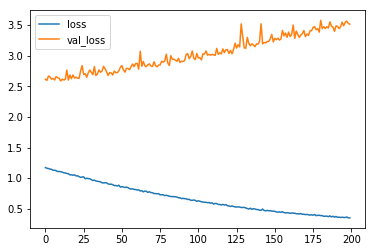

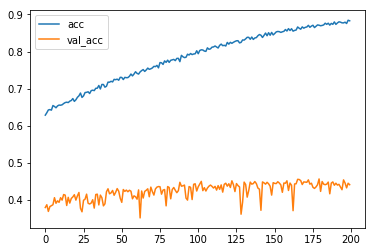

In [197]:
filepath = "./weights/2LSTM-{epoch:02d}-{loss:.4f}.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)

plot = live_plot()

callbacks_list = [checkpoint, plot]     
fit_data = model.fit(X.reshape(9976, 10,1), Y, validation_split=0.20,epochs=200, batch_size=64, callbacks=callbacks_list)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


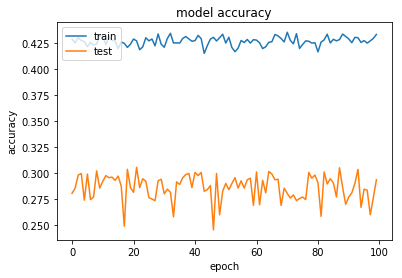

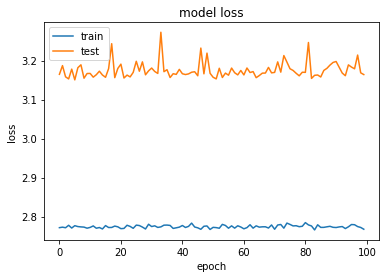

In [155]:
import matplotlib.pyplot as plt

print(fit_data.history.keys())
# summarize history for accuracy
plt.plot(fit_data.history['acc'])
plt.plot(fit_data.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(fit_data.history['loss'])
plt.plot(fit_data.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [200]:
#Generate 200 notes

#random sequence to initialize predictions
init = X[np.random.randint(0,len(X))]

predicted_notes = np.zeros(200 + input_length)
predicted_notes[0:input_length] = init

for note_index in range(200):
    x = predicted_notes[note_index:note_index + input_length]
    #print('Input: {}'.format(x))
    prediction = model.predict(x.reshape(1,10,1))
    #print('Prediction: {}'.format(np.argmax(prediction)))
    predicted_notes[note_index + input_length] = sorted_notes[np.argmax(prediction)] / max_note

In [201]:
predicted_notes * max_note

array([72., 72., 69., 69., 68., 68., 76., 76., 74., 74., 72., 74., 71.,
       69., 69., 68., 74., 69., 72., 68., 71., 69., 67., 69., 67., 69.,
       71., 67., 69., 67., 69., 65., 67., 62., 69., 67., 67., 67., 64.,
       65., 65., 60., 65., 63., 63., 69., 69., 60., 64., 67., 65., 60.,
       60., 67., 60., 63., 65., 64., 63., 65., 60., 65., 60., 60., 62.,
       59., 60., 64., 64., 59., 60., 60., 60., 60., 60., 58., 60., 60.,
       60., 60., 59., 59., 59., 57., 55., 57., 56., 56., 51., 51., 50.,
       56., 60., 51., 59., 57., 59., 62., 60., 58., 65., 62., 68., 65.,
       65., 64., 67., 61., 65., 64., 60., 63., 65., 66., 60., 65., 60.,
       68., 72., 65., 70., 72., 67., 67., 64., 60., 45., 64., 56., 53.,
       53., 69., 57., 62., 56., 42., 65., 43., 65., 76., 69., 42., 64.,
       53., 45., 71., 66., 51., 57., 68., 44., 69., 63., 59., 67., 69.,
       50., 42., 55., 72., 67., 47., 45., 41., 61., 65., 46., 68., 71.,
       65., 66., 71., 40., 64., 50., 40., 68., 47., 47., 61., 64

In [208]:
midi_functions.create_midi_from_notes(predicted_notes)

AttributeError: module 'midi_functions' has no attribute 'create_midi_from_notes'